In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file read_csv
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
tf.__version__



'2.8.0'

In [3]:
keras.__version__

'2.8.0'

In [4]:
#Reading Data from the csv fle 
df = pd.read_csv(
  "london_merged.csv",
  parse_dates=['timestamp'],index_col='timestamp')

In [5]:
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [6]:
df['hour'] = df.index.hour
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

In [7]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

<AxesSubplot:xlabel='timestamp', ylabel='cnt'>

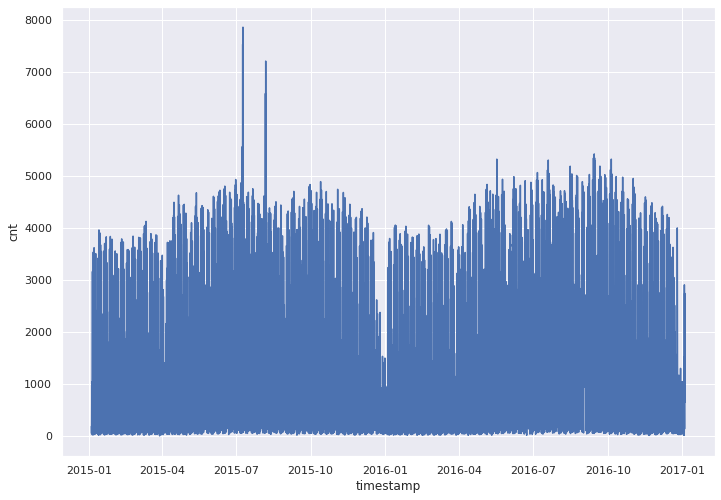

In [8]:
sns.lineplot(x=df.index, y='cnt', data=df)

<AxesSubplot:xlabel='timestamp', ylabel='cnt'>

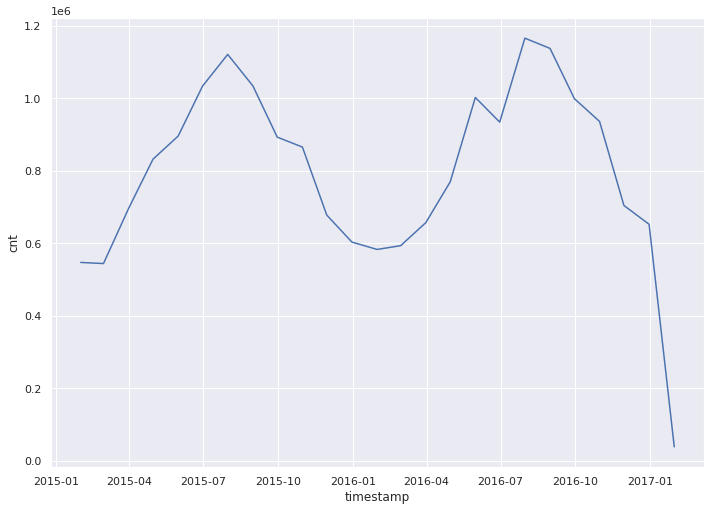

In [53]:
data_by_month = df.resample('M').sum()
data_by_month
sns.lineplot(x=data_by_month.index, y='cnt', data=data_by_month)

<AxesSubplot:xlabel='hour', ylabel='cnt'>

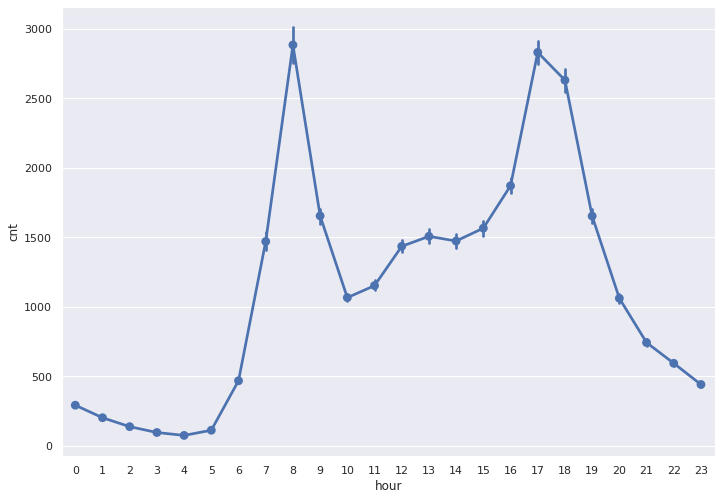

In [54]:
sns.pointplot(data=df, x='hour', y='cnt')

<AxesSubplot:xlabel='hour', ylabel='cnt'>

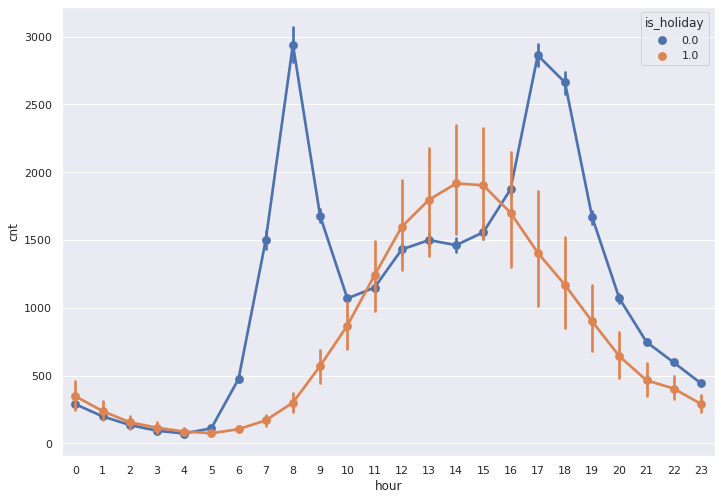

In [55]:
sns.pointplot(data=df, x='hour', y='cnt', hue='is_holiday')

<AxesSubplot:xlabel='hour', ylabel='cnt'>

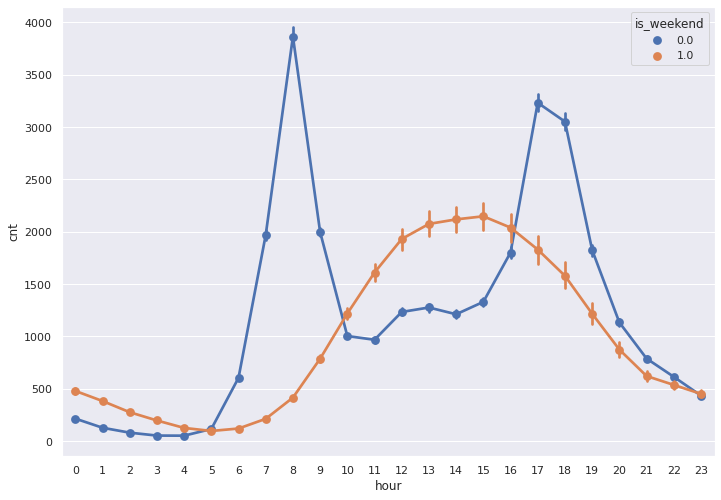

In [56]:
sns.pointplot(data=df, x='hour', y='cnt', hue='is_weekend')

<AxesSubplot:xlabel='day_of_week', ylabel='cnt'>

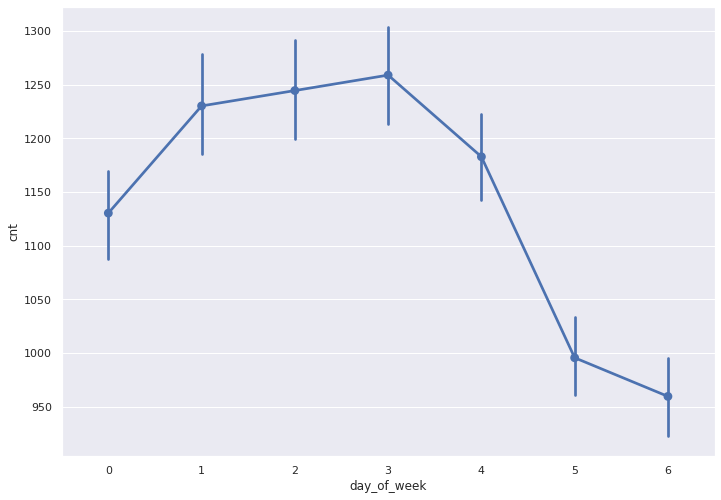

In [57]:
sns.pointplot(data=df, x='day_of_week', y='cnt')

<AxesSubplot:xlabel='hour', ylabel='cnt'>

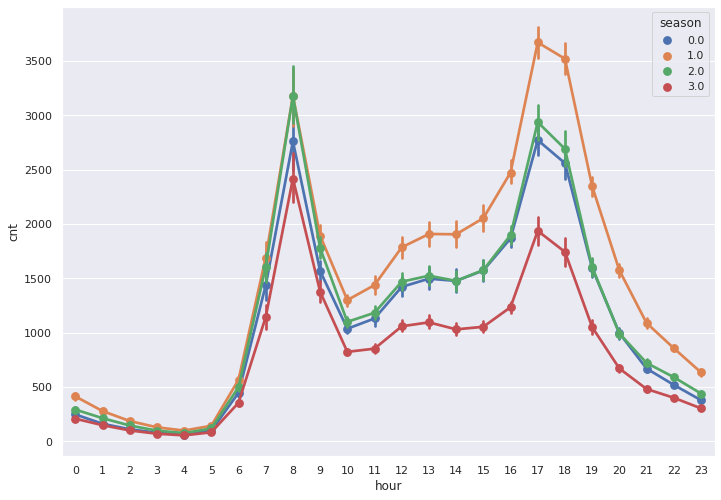

In [58]:
sns.pointplot(data=df, x='hour', y='cnt', hue='season')

In [15]:
#Spliting Data into the training and test data 
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
(len(df),train_size,test_size)

(17414, 15672, 1742)

In [16]:
train , test = df.iloc[:train_size], df.iloc[train_size:]

In [17]:
(train.shape, test.shape)

((15672, 13), (1742, 13))

In [18]:
print(train.shape)
print(test.shape)


(15672, 13)
(1742, 13)


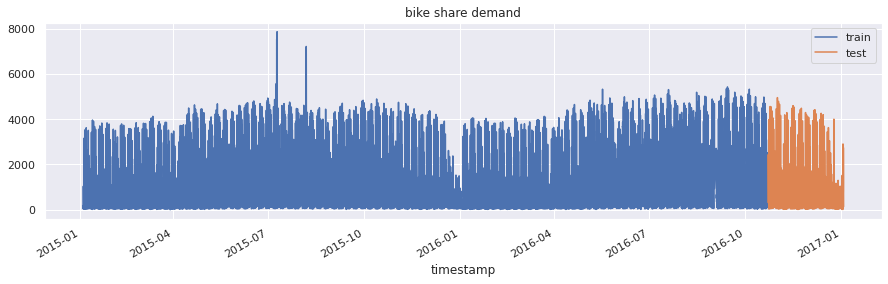

In [19]:
df['cnt'][:15672].plot(figsize=(15,4),legend=True)
df['cnt'][15672:].plot(figsize=(15,4),legend=True)
plt.legend(['train','test'])
plt.title('bike share demand')
plt.show()

In [20]:
#to scale some of the features by using robustscaler  for our modeling:
from sklearn.preprocessing import RobustScaler

f_columns = ['t1', 't2', 'hum', 'wind_speed']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['cnt']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['cnt'] = cnt_transformer.transform(train[['cnt']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['cnt'] = cnt_transformer.transform(test[['cnt']])

/home/srmtech/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-20-66a3214f2283>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['cnt'] = cnt_transformer.transform(train[['cnt']])
/home/srmtech/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [21]:
cnt_transformer.get_params()

{'copy': True,
 'quantile_range': (25.0, 75.0),
 'unit_variance': False,
 'with_centering': True,
 'with_scaling': True}

In [22]:
f_transformer.get_params()

{'copy': True,
 'quantile_range': (25.0, 75.0),
 'unit_variance': False,
 'with_centering': True,
 'with_scaling': True}

In [23]:
#to prepare sequence by using create_dataset() function.

def create_dataset(X, y, time_steps=1):
    Xs, ys= [], []
    for i in range(len(X)-time_steps):
        v = X.iloc[i:i+time_steps].values
        Xs.append(v)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)

In [24]:
TIME_STEPS = 24

X_train, y_train = create_dataset(train, train.cnt, time_steps=TIME_STEPS)
X_test , y_test = create_dataset(test, test.cnt, time_steps=TIME_STEPS)


In [25]:
(X_train.shape, y_train.shape)

((15648, 24, 13), (15648,))

In [26]:
(X_test.shape, y_test.shape)

((1718, 24, 13), (1718,))

In [27]:
!pip3 install --upgrade pip

In [28]:
!pip3 install --upgrade tensorflow 

In [29]:
import tensorflow
from tensorflow.keras import layers
import tensorflow.keras as keras


In [30]:
import tensorflow as tf
tf.__version__

'2.8.0'

In [31]:
keras.Sequential()

In [32]:
#Predicting Demand


model = keras.Sequential()
model.add(keras.layers.Bidirectional(
            keras.layers.LSTM(
            units=128,
            input_shape=(X_train.shape[1], X_train.shape[2])
            )))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))



In [35]:
#compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

In [36]:
history = model.fit(X_train, y_train, epochs=12, batch_size=32,
                   validation_split=0.1, shuffle=False)

Epoch 1/12
441/441 [==============================] - 34s 68ms/step - loss: 0.2716 - val_loss: 0.1876
Epoch 2/12
441/441 [==============================] - 30s 69ms/step - loss: 0.1051 - val_loss: 0.0976
Epoch 3/12
441/441 [==============================] - 31s 69ms/step - loss: 0.0655 - val_loss: 0.0476
Epoch 4/12
441/441 [==============================] - 31s 71ms/step - loss: 0.0497 - val_loss: 0.0472
Epoch 5/12
441/441 [==============================] - 29s 65ms/step - loss: 0.0398 - val_loss: 0.0366
Epoch 6/12
441/441 [==============================] - 31s 70ms/step - loss: 0.0355 - val_loss: 0.0378
Epoch 7/12
441/441 [==============================] - 31s 71ms/step - loss: 0.0306 - val_loss: 0.0326
Epoch 8/12
441/441 [==============================] - 31s 70ms/step - loss: 0.0281 - val_loss: 0.0351
Epoch 9/12
441/441 [==============================] - 31s 71ms/step - loss: 0.0258 - val_loss: 0.0389
Epoch 10/12
441/441 [==============================] - 32s 72ms/step - loss: 0.024

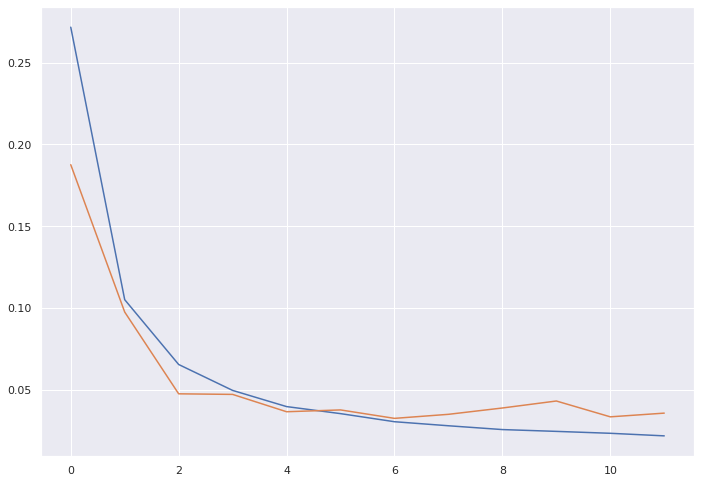

In [37]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.show()

In [38]:
y_pred = model.predict(X_test)

In [43]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)


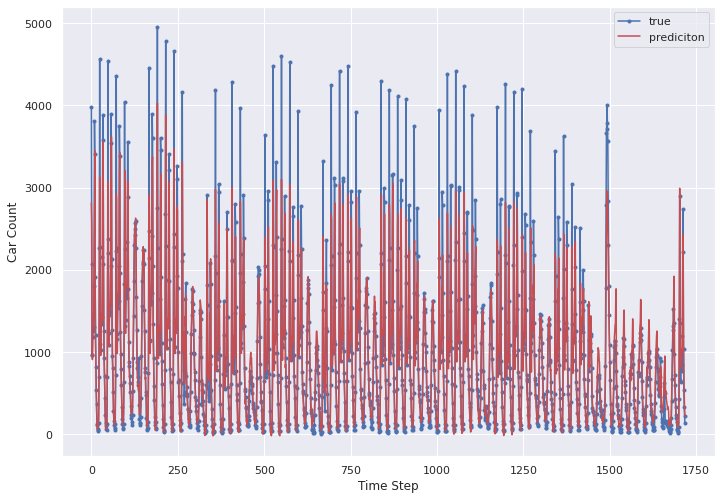

In [46]:
plt.plot(y_test_inv.flatten(), marker='.', label='true')
plt.plot(y_pred_inv.flatten(),'r', label='prediciton') #predicted
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show()

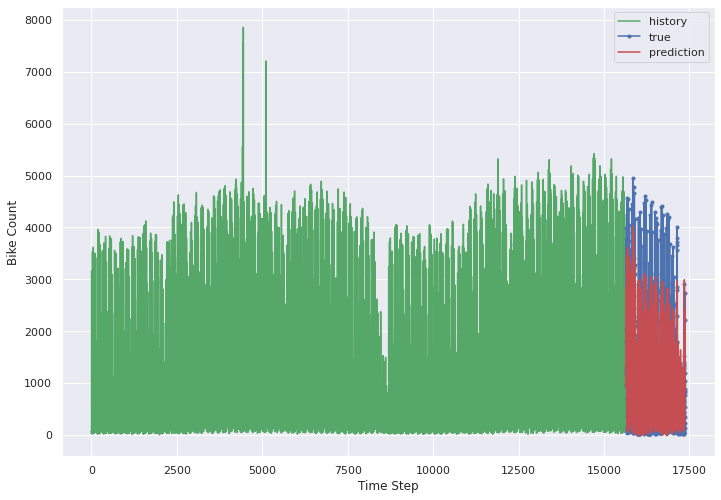

In [60]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();